In [2]:
#!pip uninstall -y catboost numpy
#!pip install numpy catboost --no-cache-dir
#!pip install scikit-learn
#!pip install pytorch-tabnet


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
from IPython.display import Image, display

from scipy.stats import kurtosis, poisson, chi2_contingency, pearsonr, stats
import scipy.stats as st
import statsmodels.api as sm

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv1D, LSTM, Dense, TimeDistributed, Input,
    BatchNormalization, Bidirectional, Attention, Concatenate
)

from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb


In [4]:
df1 = pd.read_csv('/content/airlines_group1.csv')

In [5]:
df1.head()

,date,airline,origin,destination,sched_dep_time,actual_dep_time,dep_delay,dep_delay_min,taxi_out,taxi_in,...,actual_duration,air_time,dist,dist_group,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,week
0,2020-10-15,United Airlines,"Charlotte, NC","Washington, DC",Afternoon,1444.0,-1.0,0.0,53.0,8.0,...,116.0,55.0,322.0,2,0.0,0.0,19.0,0.0,0.0,42
1,2020-10-23,United Airlines,"Pittsburgh, PA","Houston, TX",Afternoon,1611.0,-4.0,0.0,8.0,8.0,...,213.0,197.0,1117.0,5,0.0,0.0,16.0,0.0,0.0,43
2,2020-10-20,United Airlines,"Louisville, KY","Houston, TX",Morning,700.0,0.0,0.0,29.0,5.0,...,182.0,148.0,788.0,4,0.0,0.0,32.0,0.0,0.0,43
3,2020-10-20,United Airlines,"Little Rock, AR","Houston, TX",Morning,709.0,-1.0,0.0,59.0,8.0,...,129.0,62.0,374.0,2,0.0,0.0,29.0,0.0,0.0,43
4,2020-10-17,United Airlines,"Washington, DC","Sarasota/Bradenton, FL",Morning,1153.0,83.0,83.0,10.0,2.0,...,136.0,124.0,849.0,4,0.0,0.0,70.0,0.0,0.0,42


In [6]:
# Filter data for a specific airline (e.g., 'United Airlines')
df_airline = df1[df1['airline'] == 'United Airlines']

# Convert 'date' to datetime
df_airline['date'] = pd.to_datetime(df_airline['date'])

# Filter date range from 2020-10-19 to 2023-04-23
df_airline = df_airline[(df_airline['date'] >= '2020-10-19') & (df_airline['date'] <= '2023-04-23')]

# Group by date and sum arrival and departure delays
delays_by_date = df_airline.groupby('date')[['arr_delay', 'dep_delay']].sum().reset_index()

<ipython-input-6-72b75e12749e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_airline['date'] = pd.to_datetime(df_airline['date'])


In [7]:
x_val = np.arange(len(delays_by_date)).reshape(-1, 1)
y_val1 = delays_by_date['arr_delay']
y_val2 = delays_by_date['dep_delay']

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Attention, Input, Conv1D, Flatten


def flatten_sequences(X):
    return X.reshape(X.shape[0], -1)

# Train-test split (80% training, 20% testing)
X_train1, X_test1, y_train1, y_test1 = train_test_split(flatten_sequences(x_val), y_val1, test_size=0.2, shuffle=False)
X_train2, X_test2, y_train2, y_test2 = train_test_split(flatten_sequences(x_val), y_val2, test_size=0.2, shuffle=False)

# --- Random Forest Regressor ---
rf1 = RandomForestRegressor(n_estimators=100, random_state=42)
rf2 = RandomForestRegressor(n_estimators=100, random_state=42)
rf1.fit(X_train1, y_train1)
rf2.fit(X_train2, y_train2)
y_pred_rf1 = rf1.predict(X_test1)
y_pred_rf2 = rf2.predict(X_test2)
rmse_rf1 = np.sqrt(mean_squared_error(y_test1, y_pred_rf1))
rmse_rf2 = np.sqrt(mean_squared_error(y_test2, y_pred_rf2))

# --- Gradient Boosting Regressor ---
gb1 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb2 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb1.fit(X_train1, y_train1)
gb2.fit(X_train2, y_train2)
y_pred_gb1 = gb1.predict(X_test1)
y_pred_gb2 = gb2.predict(X_test2)
rmse_gb1 = np.sqrt(mean_squared_error(y_test1, y_pred_gb1))
rmse_gb2 = np.sqrt(mean_squared_error(y_test2, y_pred_gb2))

# --- XGBoost ---
xgb1 = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8)
xgb2 = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8)
xgb1.fit(X_train1, y_train1)
xgb2.fit(X_train2, y_train2)
y_pred_xgb1 = xgb1.predict(X_test1)
y_pred_xgb2 = xgb2.predict(X_test2)
rmse_xgb1 = np.sqrt(mean_squared_error(y_test1, y_pred_xgb1))
rmse_xgb2 = np.sqrt(mean_squared_error(y_test2, y_pred_xgb2))

# --- Linear Regression ---
lin_reg1 = LinearRegression()
lin_reg2 = LinearRegression()
lin_reg1.fit(X_train1, y_train1)
lin_reg2.fit(X_train2, y_train2)
y_pred_lin1 = lin_reg1.predict(X_test1)
y_pred_lin2 = lin_reg2.predict(X_test2)
rmse_lin1 = np.sqrt(mean_squared_error(y_test1, y_pred_lin1))
rmse_lin2 = np.sqrt(mean_squared_error(y_test2, y_pred_lin2))

# --- Polynomial Regression ---
poly = PolynomialFeatures(degree=2)
X_train1_poly = poly.fit_transform(X_train1)
X_test1_poly = poly.transform(X_test1)
X_train2_poly = poly.fit_transform(X_train2)
X_test2_poly = poly.transform(X_test2)
poly_reg1 = LinearRegression()
poly_reg2 = LinearRegression()
poly_reg1.fit(X_train1_poly, y_train1)
poly_reg2.fit(X_train2_poly, y_train2)
y_pred_poly1 = poly_reg1.predict(X_test1_poly)
y_pred_poly2 = poly_reg2.predict(X_test2_poly)
rmse_poly1 = np.sqrt(mean_squared_error(y_test1, y_pred_poly1))
rmse_poly2 = np.sqrt(mean_squared_error(y_test2, y_pred_poly2))

# --- CNN-LSTM ---
def build_cnn_lstm_model():
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train1.shape[1], 1)),
        LSTM(50, return_sequences=True),
        LSTM(50),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# --- Attention-based BiLSTM ---
def build_att_bilstm_model():
    inputs = Input(shape=(X_train1.shape[1], 1))
    x = Bidirectional(LSTM(50, return_sequences=True))(inputs)
    att = Attention()([x, x])
    x = LSTM(50)(att)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

# Output RMSE values
print(f'RMSE RF1: {rmse_rf1}, RF2: {rmse_rf2}')
print(f'RMSE GB1: {rmse_gb1}, GB2: {rmse_gb2}')
print(f'RMSE XGB1: {rmse_xgb1}, XGB2: {rmse_xgb2}')
print(f'RMSE LIN1: {rmse_lin1}, LIN2: {rmse_lin2}')
print(f'RMSE POLY1: {rmse_poly1}, POLY2: {rmse_poly2}')


RMSE RF1: 58118.2921338504, RF2: 46283.070383323844
RMSE GB1: 54821.394665409396, GB2: 44260.02405531852
RMSE XGB1: 55319.02757524583, XGB2: 44869.3816686317
RMSE LIN1: 39166.94809364272, LIN2: 35059.37998547645
RMSE POLY1: 63382.6016146631, POLY2: 49775.269471382475


## CNN-LSTM Model

In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense
from tensorflow.keras.layers import Input

# Sample 20% of the data for testing
df1_sampled = df1.sample(frac=0.2, random_state=42)

# Preprocessing (scaling and reshaping)
X = df1_sampled[['actual_dep_time', 'actual_arr_time', 'dep_delay', 'arr_delay', 'taxi_out', 'taxi_in',
                 'air_time', 'dist', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']].values
y_arrival = df1_sampled['arr_delay'].values
y_departure = df1_sampled['dep_delay'].values

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape for CNN-LSTM model (samples, time steps, features)
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))  # 1 time step, 13 features

# Split data into training and testing sets
X_train, X_test, y_train_arrival, y_test_arrival = train_test_split(X_reshaped, y_arrival, test_size=0.2, random_state=42, shuffle=False)
X_train, X_test, y_train_departure, y_test_departure = train_test_split(X_reshaped, y_departure, test_size=0.2, random_state=42, shuffle=False)

# Build CNN-LSTM Model
def build_cnn_lstm_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),  # Input layer with shape (time_steps, features)
        Conv1D(filters=64, kernel_size=1, activation='relu'),  # CNN layer with smaller kernel size
        LSTM(50),  # LSTM layer
        Dense(1)  # Output layer
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Initialize model for arrival delay prediction
cnn_lstm_model_arrival = build_cnn_lstm_model(X_train.shape[1:])
cnn_lstm_model_arrival.summary()

# Train the model for arrival delay
cnn_lstm_model_arrival.fit(X_train, y_train_arrival, epochs=10, batch_size=64, verbose=1)

# Evaluate the model for arrival delay
arrival_loss = cnn_lstm_model_arrival.evaluate(X_test, y_test_arrival)
print(f"Arrival delay model loss: {arrival_loss}")

# Initialize model for departure delay prediction
cnn_lstm_model_departure = build_cnn_lstm_model(X_train.shape[1:])
cnn_lstm_model_departure.summary()

# Train the model for departure delay
cnn_lstm_model_departure.fit(X_train, y_train_departure, epochs=10, batch_size=64, verbose=1)

# Evaluate the model for departure delay
departure_loss = cnn_lstm_model_departure.evaluate(X_test, y_test_departure)
print(f"Departure delay model loss: {departure_loss}")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 1, 64)               │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 50)                  │          23,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,947 (93.54 KB)

 Trainable params: 23,947 (93.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 110s 5ms/step - loss: 2108.1475
Epoch 2/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 102s 5ms/step - loss: 775.5628
Epoch 3/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 141s 5ms/step - loss: 335.1836
Epoch 4/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 72s 4ms/step - loss: 165.9326
Epoch 5/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - loss: 135.9424
Epoch 6/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 83s 3ms/step - loss: 105.1524
Epoch 7/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 87s 3ms/step - loss: 73.2495
Epoch 8/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step - loss: 60.3727
Epoch 9/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step - loss: 53.2728
Epoch 10/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 85s 3ms/step - loss: 87.3994
9640/9640 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 44.4443
Arrival delay model loss: 32.68545150756836


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 1, 64)               │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          23,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,947 (93.54 KB)

 Trainable params: 23,947 (93.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 60s 3ms/step - loss: 2079.3926
Epoch 2/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step - loss: 705.0941
Epoch 3/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step - loss: 344.6398
Epoch 4/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step - loss: 211.0690
Epoch 5/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 64s 3ms/step - loss: 114.8630
Epoch 6/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 74s 3ms/step - loss: 99.7254
Epoch 7/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step - loss: 77.2809
Epoch 8/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step - loss: 45.4519
Epoch 9/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step - loss: 44.5806
Epoch 10/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - loss: 59.0407
9640/9640 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 62.2410
Departure delay model loss: 49.53706741333008


## CNN-LSTM Model Evaluation

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predict arrival and departure delays
y_pred_arrival = cnn_lstm_model_arrival.predict(X_test).flatten()
y_pred_departure = cnn_lstm_model_departure.predict(X_test).flatten()

# Compute performance metrics for arrival delay
mae_arrival0 = mean_absolute_error(y_test_arrival, y_pred_arrival)
mse_arrival0 = mean_squared_error(y_test_arrival, y_pred_arrival)
rmse_arrival0 = np.sqrt(mse_arrival0)
r2_arrival0 = r2_score(y_test_arrival, y_pred_arrival)

# Compute performance metrics for departure delay
mae_departure0 = mean_absolute_error(y_test_departure, y_pred_departure)
mse_departure0 = mean_squared_error(y_test_departure, y_pred_departure)
rmse_departure0 = np.sqrt(mse_departure0)
r2_departure0 = r2_score(y_test_departure, y_pred_departure)

# Print results in formatted output
print()
print("CNN-LSTM")
print(f"Metric         | Arrival Delay       | Departure Delay")
print(f"-------------------------------------------------")
print(f"MAE            | {mae_arrival0:.4f}       | {mae_departure0:.4f}")
print(f"MSE            | {mse_arrival0:.4f}      | {mse_departure0:.4f}")
print(f"RMSE           | {rmse_arrival0:.4f}       | {rmse_departure0:.4f}")
print(f"R² Score       | {r2_arrival0:.4f}       | {r2_departure0:.4f}")


9640/9640 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
9640/9640 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step

CNN-LSTM
Metric         | Arrival Delay       | Departure Delay
-------------------------------------------------
MAE            | 0.2815       | 0.5175
MSE            | 32.6854      | 49.5371
RMSE           | 5.7171       | 7.0383
R² Score       | 0.9917       | 0.9864


## CNN-LSTM Model Pediction graph

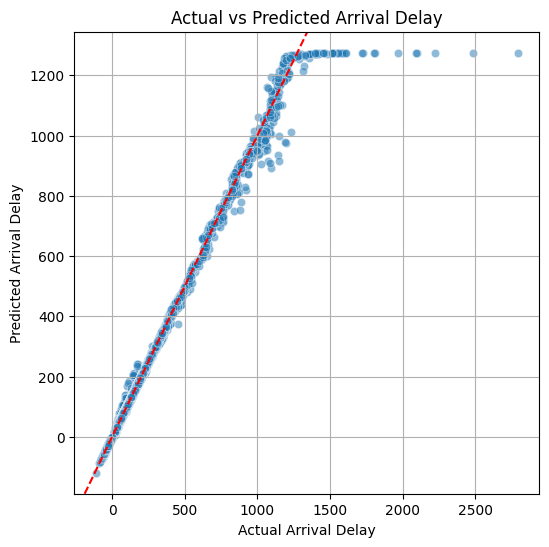

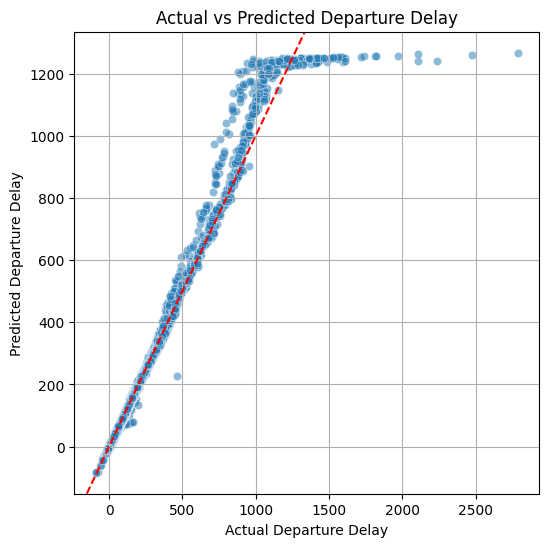

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot for arrival delay predictions
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test_arrival, y=y_pred_arrival, alpha=0.5)
plt.xlabel("Actual Arrival Delay")
plt.ylabel("Predicted Arrival Delay")
plt.title("Actual vs Predicted Arrival Delay")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Perfect prediction line
plt.grid()
plt.show()

# Scatter plot for departure delay predictions
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test_departure, y=y_pred_departure, alpha=0.5)
plt.xlabel("Actual Departure Delay")
plt.ylabel("Predicted Departure Delay")
plt.title("Actual vs Predicted Departure Delay")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Perfect prediction line
plt.grid()
plt.show()


## ATT-BI-LSTM Model

In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional, Attention

# Sample 20% of the data for testing
df1_sampled = df1.sample(frac=0.2, random_state=42)

# Preprocessing (scaling and reshaping)
X = df1_sampled[['actual_dep_time', 'actual_arr_time', 'dep_delay', 'arr_delay', 'taxi_out', 'taxi_in',
                 'air_time', 'dist', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']].values
y_arrival = df1_sampled['arr_delay'].values
y_departure = df1_sampled['dep_delay'].values

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape for BiLSTM (samples, time steps, features)
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))  # 1 time step, 13 features

# Split data into training and testing sets
X_train, X_test, y_train_arrival, y_test_arrival = train_test_split(X_reshaped, y_arrival, test_size=0.2, random_state=42, shuffle=False)
X_train, X_test, y_train_departure, y_test_departure = train_test_split(X_reshaped, y_departure, test_size=0.2, random_state=42, shuffle=False)

# Build ATT-BI-LSTM Model
def build_att_bilstm_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Bidirectional(LSTM(50, return_sequences=True))(inputs)
    attention = Attention()([x, x])  # Self-attention mechanism
    x = tf.keras.layers.GlobalAveragePooling1D()(attention)  # Global pooling after attention
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

# Initialize and train model for arrival delay prediction
att_bilstm_model_arrival = build_att_bilstm_model(X_train.shape[1:])
att_bilstm_model_arrival.summary()
att_bilstm_model_arrival.fit(X_train, y_train_arrival, epochs=10, batch_size=64, verbose=1)

# Evaluate the model for arrival delay
arrival_loss1 = att_bilstm_model_arrival.evaluate(X_test, y_test_arrival)
print(f"Arrival delay model loss: {arrival_loss1}")

# Initialize and train model for departure delay prediction
att_bilstm_model_departure = build_att_bilstm_model(X_train.shape[1:])
att_bilstm_model_departure.summary()
att_bilstm_model_departure.fit(X_train, y_train_departure, epochs=10, batch_size=64, verbose=1)

# Evaluate the model for departure delay
departure_loss1 = att_bilstm_model_departure.evaluate(X_test, y_test_departure)
print(f"Departure delay model loss: {departure_loss1}")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 1, 13)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 1, 100)         │         25,600 │ input_layer_2[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 1, 100)         │              0 │ bidirectional[0][0],   │
│                           │                        │                │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 100)            │              0 │ attention[0][0]        │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │            101 │ global_average_poolin… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 25,701 (100.39 KB)

 Trainable params: 25,701 (100.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


19279/19279 ━━━━━━━━━━━━━━━━━━━━ 73s 4ms/step - loss: 1699.4858
Epoch 2/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 81s 4ms/step - loss: 306.4868
Epoch 3/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 87s 4ms/step - loss: 136.1080
Epoch 4/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step - loss: 79.0861
Epoch 5/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step - loss: 63.8094
Epoch 6/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - loss: 28.5915
Epoch 7/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - loss: 30.5904
Epoch 8/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step - loss: 26.3995
Epoch 9/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step - loss: 47.6069
Epoch 10/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - loss: 25.8435
9640/9640 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 19.9459
Arrival delay model loss: 13.783591270446777


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 1, 13)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 1, 100)         │         25,600 │ input_layer_3[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_1 (Attention)   │ (None, 1, 100)         │              0 │ bidirectional_1[0][0], │
│                           │                        │                │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 100)            │              0 │ attention_1[0][0]      │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │            101 │ global_average_poolin… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 25,701 (100.39 KB)

 Trainable params: 25,701 (100.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 75s 4ms/step - loss: 1562.3560
Epoch 2/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 72s 4ms/step - loss: 336.0957
Epoch 3/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 75s 4ms/step - loss: 122.3332
Epoch 4/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 78s 4ms/step - loss: 65.0841
Epoch 5/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 76s 4ms/step - loss: 45.5841
Epoch 6/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - loss: 57.1669
Epoch 7/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step - loss: 29.0313
Epoch 8/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - loss: 33.2837
Epoch 9/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step - loss: 20.7475
Epoch 10/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 72s 4ms/step - loss: 19.9687
9640/9640 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 20.6618
Departure delay model loss: 15.416438102722168


## ATT-BI-LSTM Model Evaluation

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predict arrival and departure delays
y_pred_arrival1 = att_bilstm_model_arrival.predict(X_test).flatten()
y_pred_departure1 = att_bilstm_model_departure.predict(X_test).flatten()

# Compute performance metrics for arrival delay
mae_arrival1 = mean_absolute_error(y_test_arrival, y_pred_arrival1)
mse_arrival1 = mean_squared_error(y_test_arrival, y_pred_arrival1)
rmse_arrival1 = np.sqrt(mse_arrival1)
r2_arrival1 = r2_score(y_test_arrival, y_pred_arrival1)

# Compute performance metrics for departure delay
mae_departure1 = mean_absolute_error(y_test_departure, y_pred_departure1)
mse_departure1 = mean_squared_error(y_test_departure, y_pred_departure1)
rmse_departure1 = np.sqrt(mse_departure1)
r2_departure1 = r2_score(y_test_departure, y_pred_departure1)

# Print results in a formatted table
print()
print("ATT-BI-LSTM")
print(f"Metric          | Arrival Delay  | Departure Delay")
print(f"-------------------------------------------------")
print(f"MAE            | {mae_arrival1:.4f}       | {mae_departure1:.4f}")
print(f"MSE            | {mse_arrival1:.4f}       | {mse_departure1:.4f}")
print(f"RMSE           | {rmse_arrival1:.4f}       | {rmse_departure1:.4f}")
print(f"R² Score       | {r2_arrival1:.4f}       | {r2_departure1:.4f}")


  37/9640 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step    

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


9640/9640 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
9640/9640 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step

ATT-BI-LSTM
Metric          | Arrival Delay  | Departure Delay
-------------------------------------------------
MAE            | 0.4117       | 0.3797
MSE            | 13.7836       | 15.4164
RMSE           | 3.7126       | 3.9264
R² Score       | 0.9965       | 0.9958


## ATT-BI-LSTM Model Prediction Graph

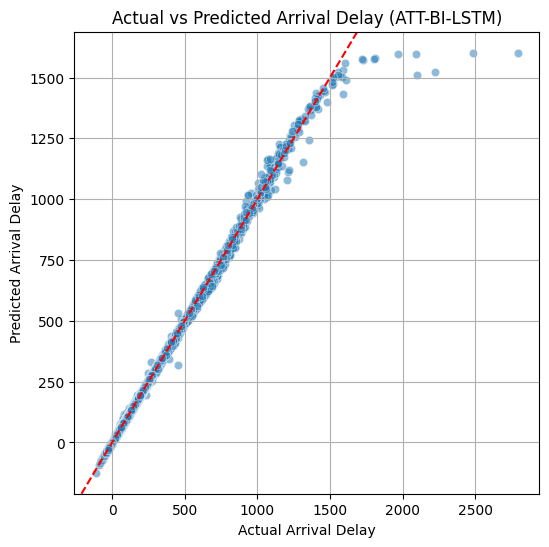

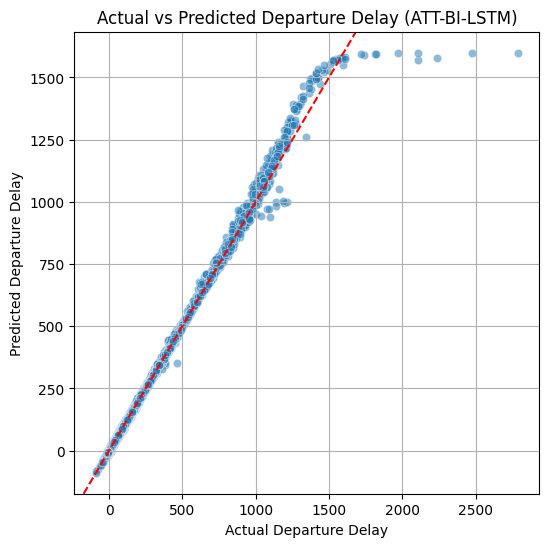

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot for arrival delay predictions
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test_arrival, y=y_pred_arrival1, alpha=0.5)
plt.xlabel("Actual Arrival Delay")
plt.ylabel("Predicted Arrival Delay")
plt.title("Actual vs Predicted Arrival Delay (ATT-BI-LSTM)")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Perfect prediction line
plt.grid()
plt.show()

# Scatter plot for departure delay predictions
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test_departure, y=y_pred_departure1, alpha=0.5)
plt.xlabel("Actual Departure Delay")
plt.ylabel("Predicted Departure Delay")
plt.title("Actual vs Predicted Departure Delay (ATT-BI-LSTM)")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Perfect prediction line
plt.grid()
plt.show()


## Random Forest

In [15]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Sample 20% of the data for testing
df1_sampled = df1.sample(frac=0.2, random_state=42)

# Extract features and target variables
X = df1_sampled[['actual_dep_time', 'actual_arr_time', 'dep_delay', 'arr_delay', 'taxi_out', 'taxi_in',
                 'air_time', 'dist', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']].values
y_arrival = df1_sampled['arr_delay'].values
y_departure = df1_sampled['dep_delay'].values

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Keep as 2D array, no reshaping needed

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train_arrival, y_test_arrival = train_test_split(X_scaled, y_arrival, test_size=0.2, random_state=42, shuffle=False)
X_train, X_test, y_train_departure, y_test_departure = train_test_split(X_scaled, y_departure, test_size=0.2, random_state=42, shuffle=False)

# Train Random Forest for Arrival Delay Prediction
rf_arrival = RandomForestRegressor(n_estimators=100, random_state=42)
rf_arrival.fit(X_train, y_train_arrival)
y_pred_arrival1 = rf_arrival.predict(X_test)

# Train Random Forest for Departure Delay Prediction
rf_departure = RandomForestRegressor(n_estimators=100, random_state=42)
rf_departure.fit(X_train, y_train_departure)
y_pred_departure1 = rf_departure.predict(X_test)

# Calculate RMSE for both models
rmse_arrival_1 = np.sqrt(mean_squared_error(y_test_arrival, y_pred_arrival1))
rmse_departure_1 = np.sqrt(mean_squared_error(y_test_departure, y_pred_departure1))

# Print RMSE values
print(f"RMSE (Random Forest) - Arrival Delay: {rmse_arrival_1:.4f}")
print(f"RMSE (Random Forest) - Departure Delay: {rmse_departure_1:.4f}")


RMSE (Random Forest) - Arrival Delay: 0.2051
RMSE (Random Forest) - Departure Delay: 0.2085


## Random Forest Evaluation

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate Mean Absolute Error (MAE) for both models
mae_arrival2 = mean_absolute_error(y_test_arrival, y_pred_arrival1)
mae_departure2 = mean_absolute_error(y_test_departure, y_pred_departure1)

# Calculate Mean Squared Error (MSE) for both models
mse_arrival2 = mean_squared_error(y_test_arrival, y_pred_arrival1)
mse_departure2 = mean_squared_error(y_test_departure, y_pred_departure1)

# Calculate Root Mean Squared Error (RMSE) for both models
rmse_arrival_1 = np.sqrt(mse_arrival2)
rmse_departure_1 = np.sqrt(mse_departure2)

# Calculate R-squared (R²) for both models
r2_arrival2 = r2_score(y_test_arrival, y_pred_arrival1)
r2_departure2 = r2_score(y_test_departure, y_pred_departure1)

# Printing performance metrics in the requested format
print()
print("Random Forest")
print(f"Metric          | Arrival Delay  | Departure Delay")
print(f"-------------------------------------------------")
print(f"MAE            | {mae_arrival2:.4f}       | {mae_departure2:.4f}")
print(f"MSE            | {mse_arrival2:.4f}       | {mse_departure2:.4f}")
print(f"RMSE           | {rmse_arrival_1:.4f}       | {rmse_departure_1:.4f}")
print(f"R² Score       | {r2_arrival2:.4f}       | {r2_departure2:.4f}")



Random Forest
Metric          | Arrival Delay  | Departure Delay
-------------------------------------------------
MAE            | 0.0015       | 0.0015
MSE            | 0.0421       | 0.0435
RMSE           | 0.2051       | 0.2085
R² Score       | 1.0000       | 1.0000


## Random Forest Prediction graph

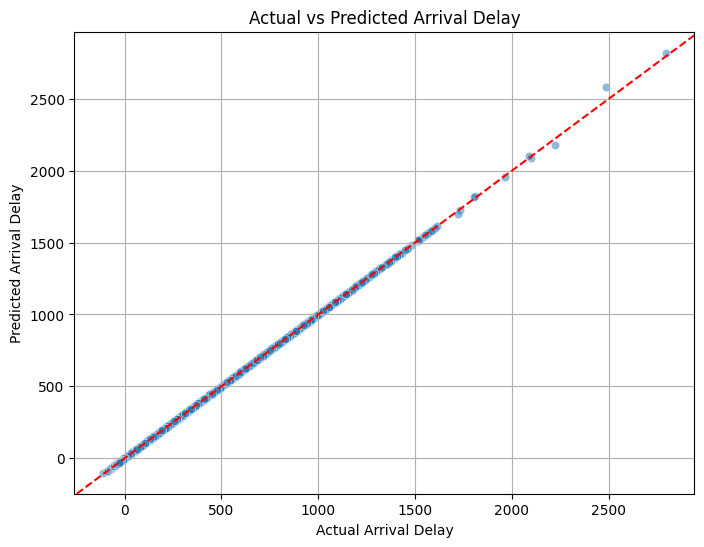

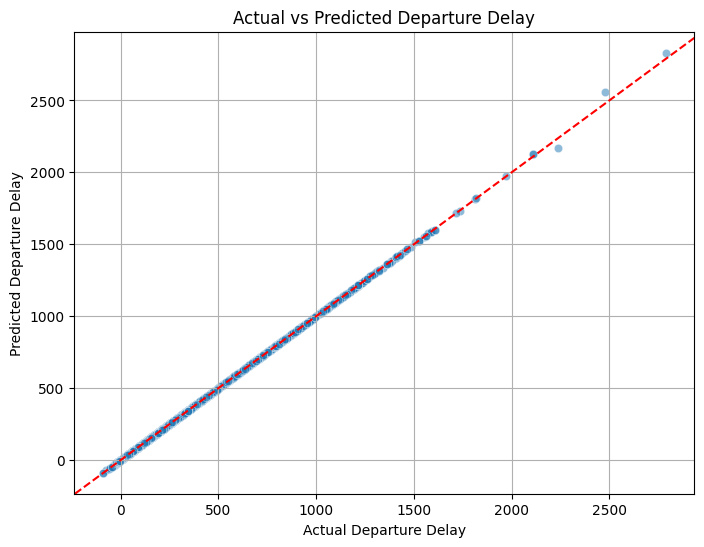

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot for arrival delay predictions
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_arrival, y=y_pred_arrival1, alpha=0.5)
plt.xlabel("Actual Arrival Delay")
plt.ylabel("Predicted Arrival Delay")
plt.title("Actual vs Predicted Arrival Delay")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Perfect prediction line
plt.grid(True)
plt.show()

# Scatter plot for departure delay predictions
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_departure, y=y_pred_departure1, alpha=0.5)
plt.xlabel("Actual Departure Delay")
plt.ylabel("Predicted Departure Delay")
plt.title("Actual vs Predicted Departure Delay")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Perfect prediction line
plt.grid(True)
plt.show()


##  Gradient Boosting Regressor

In [18]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Sample 20% of the data for testing
df1_sampled = df1.sample(frac=0.2, random_state=42)

# Select relevant features and target variables
X = df1_sampled[['actual_dep_time', 'actual_arr_time', 'dep_delay', 'arr_delay', 'taxi_out', 'taxi_in',
                 'air_time', 'dist', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']].values
y_arrival = df1_sampled['arr_delay'].values
y_departure = df1_sampled['dep_delay'].values

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # No need to reshape for GBR (tabular model)

# Split data into training and testing sets
X_train, X_test, y_train_arrival, y_test_arrival = train_test_split(X_scaled, y_arrival, test_size=0.2, random_state=42, shuffle=False)
X_train, X_test, y_train_departure, y_test_departure = train_test_split(X_scaled, y_departure, test_size=0.2, random_state=42, shuffle=False)

# --- Train Gradient Boosting Regressor for Arrival Delay ---
gbr_arrival = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
gbr_arrival.fit(X_train, y_train_arrival)
y_pred_arrival_2 = gbr_arrival.predict(X_test)
rmse_arrival1 = np.sqrt(mean_squared_error(y_test_arrival, y_pred_arrival_2))
print(f"GBR Arrival Delay RMSE: {rmse_arrival1:.4f}")

# --- Train Gradient Boosting Regressor for Departure Delay ---
gbr_departure = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
gbr_departure.fit(X_train, y_train_departure)
y_pred_departure_2 = gbr_departure.predict(X_test)
rmse_departure1 = np.sqrt(mean_squared_error(y_test_departure, y_pred_departure_2))
print(f"GBR Departure Delay RMSE: {rmse_departure1:.4f}")


GBR Arrival Delay RMSE: 0.3167
GBR Departure Delay RMSE: 0.2574


##  Gradient Boosting Regressor Evaluation

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate MAE, MSE, RMSE, and R² Score for Arrival Delay
mae_arrival_2 = mean_absolute_error(y_test_arrival, y_pred_arrival_2)
mse_arrival_2 = mean_squared_error(y_test_arrival, y_pred_arrival_2)
r2_arrival_2 = r2_score(y_test_arrival, y_pred_arrival_2)

# Calculate MAE, MSE, RMSE, and R² Score for Departure Delay
mae_departure_2 = mean_absolute_error(y_test_departure, y_pred_departure_2)
mse_departure_2 = mean_squared_error(y_test_departure, y_pred_departure_2)
r2_departure_2 = r2_score(y_test_departure, y_pred_departure_2)

# Print performance metrics
print()
print("Gradient Boosting Regressor")
print(f"Metric          | Arrival Delay  | Departure Delay")
print(f"-------------------------------------------------")
print(f"MAE            | {mae_arrival_2:.4f}       | {mae_departure_2:.4f}")
print(f"MSE            | {mse_arrival_2:.4f}       | {mse_departure_2:.4f}")
print(f"RMSE           | {rmse_arrival1:.4f}       | {rmse_departure1:.4f}")
print(f"R² Score       | {r2_arrival_2:.4f}       | {r2_departure_2:.4f}")



Gradient Boosting Regressor
Metric          | Arrival Delay  | Departure Delay
-------------------------------------------------
MAE            | 0.0246       | 0.0204
MSE            | 0.1003       | 0.0663
RMSE           | 0.3167       | 0.2574
R² Score       | 1.0000       | 1.0000


##  Gradient Boosting Regressor Prediction Graph

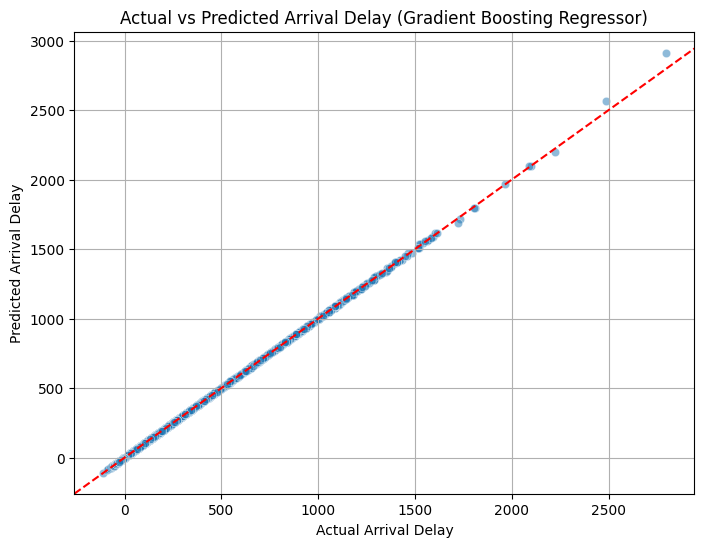

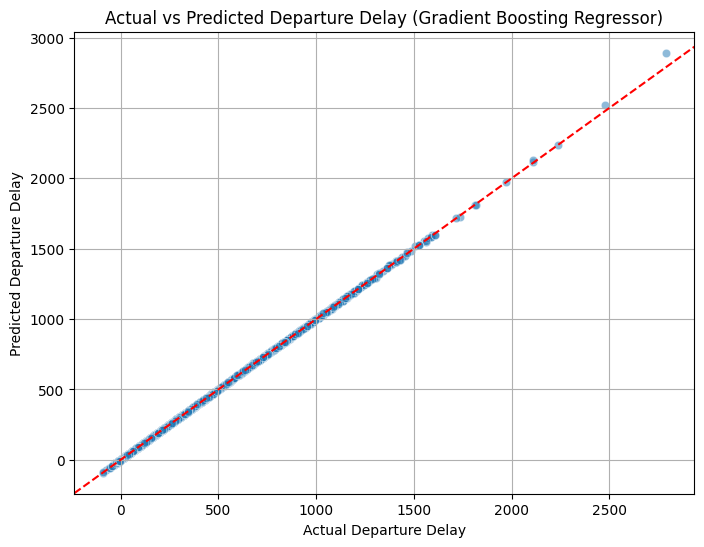

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot for arrival delay predictions
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_arrival, y=y_pred_arrival_2, alpha=0.5)
plt.xlabel("Actual Arrival Delay")
plt.ylabel("Predicted Arrival Delay")
plt.title("Actual vs Predicted Arrival Delay (Gradient Boosting Regressor)")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Perfect prediction line
plt.grid(True)
plt.show()

# Scatter plot for departure delay predictions
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_departure, y=y_pred_departure_2, alpha=0.5)
plt.xlabel("Actual Departure Delay")
plt.ylabel("Predicted Departure Delay")
plt.title("Actual vs Predicted Departure Delay (Gradient Boosting Regressor)")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Perfect prediction line
plt.grid(True)
plt.show()


## XGBoost Model

In [21]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Sample 20% of the data for testing
df1_sampled = df1.sample(frac=0.2, random_state=42)

# Select multiple features for training
X = df1_sampled[['actual_dep_time', 'actual_arr_time', 'dep_delay', 'arr_delay', 'taxi_out', 'taxi_in',
                 'air_time', 'dist', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']].values
y_arrival = df1_sampled['arr_delay'].values
y_departure = df1_sampled['dep_delay'].values

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train_arrival, y_test_arrival = train_test_split(X_scaled, y_arrival, test_size=0.2, random_state=42, shuffle=False)
X_train, X_test, y_train_departure, y_test_departure = train_test_split(X_scaled, y_departure, test_size=0.2, random_state=42, shuffle=False)

# Train XGBoost Model for Arrival Delay Prediction
xgb_arrival = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=6, learning_rate=0.1)
xgb_arrival.fit(X_train, y_train_arrival)

# Predict and Calculate RMSE for Arrival Delay
y_pred_arrival = xgb_arrival.predict(X_test)
rmse_arrival2 = np.sqrt(mean_squared_error(y_test_arrival, y_pred_arrival))
print(f"XGBoost Arrival Delay RMSE: {rmse_arrival2}")

# Train XGBoost Model for Departure Delay Prediction
xgb_departure = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=6, learning_rate=0.1)
xgb_departure.fit(X_train, y_train_departure)

# Predict and Calculate RMSE for Departure Delay
y_pred_departure = xgb_departure.predict(X_test)
rmse_departure2 = np.sqrt(mean_squared_error(y_test_departure, y_pred_departure))
print(f"XGBoost Departure Delay RMSE: {rmse_departure2}")


XGBoost Arrival Delay RMSE: 8.813758881656812
XGBoost Departure Delay RMSE: 8.870922516223741


## XGBoost Model Evaluation

In [22]:
from sklearn.metrics import mean_absolute_error, r2_score

# Calculate MAE, MSE, RMSE, and R² Score for Arrival Delay
mae_arrival_3 = mean_absolute_error(y_test_arrival, y_pred_arrival)
mse_arrival_3 = mean_squared_error(y_test_arrival, y_pred_arrival)
r2_arrival_3 = r2_score(y_test_arrival, y_pred_arrival)

# Calculate MAE, MSE, RMSE, and R² Score for Departure Delay
mae_departure_3 = mean_absolute_error(y_test_departure, y_pred_departure)
mse_departure_3 = mean_squared_error(y_test_departure, y_pred_departure)
r2_departure_3 = r2_score(y_test_departure, y_pred_departure)

# Print performance metrics
print()
print("XGBoost Regressor")
print(f"Metric          | Arrival Delay  | Departure Delay")
print(f"-------------------------------------------------")
print(f"MAE            | {mae_arrival_3:.4f}       | {mae_departure_3:.4f}")
print(f"MSE            | {mse_arrival_3:.4f}       | {mse_departure_3:.4f}")
print(f"RMSE           | {rmse_arrival2:.4f}       | {rmse_departure2:.4f}")
print(f"R² Score       | {r2_arrival_3:.4f}       | {r2_departure_3:.4f}")



XGBoost Regressor
Metric          | Arrival Delay  | Departure Delay
-------------------------------------------------
MAE            | 0.5769       | 0.5894
MSE            | 77.6823       | 78.6933
RMSE           | 8.8138       | 8.8709
R² Score       | 0.9803       | 0.9784


## XGBoost Model Prediction Graph

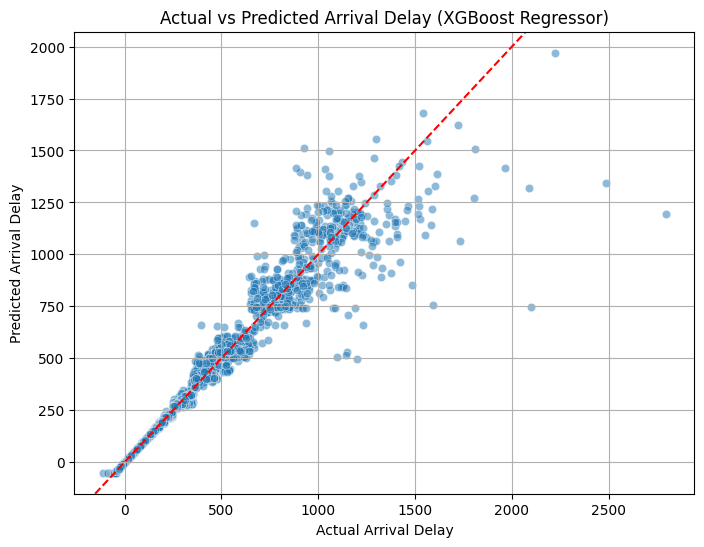

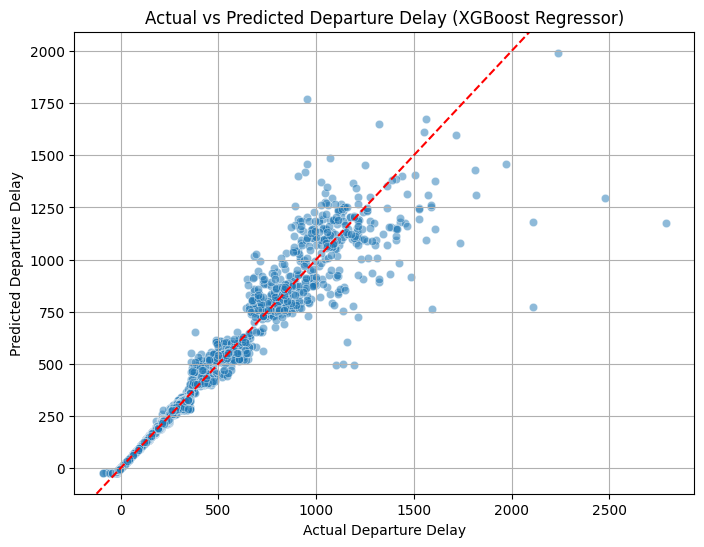

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot for arrival delay predictions
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_arrival, y=y_pred_arrival, alpha=0.5)
plt.xlabel("Actual Arrival Delay")
plt.ylabel("Predicted Arrival Delay")
plt.title("Actual vs Predicted Arrival Delay (XGBoost Regressor)")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Perfect prediction line
plt.grid(True)
plt.show()

# Scatter plot for departure delay predictions
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_departure, y=y_pred_departure, alpha=0.5)
plt.xlabel("Actual Departure Delay")
plt.ylabel("Predicted Departure Delay")
plt.title("Actual vs Predicted Departure Delay (XGBoost Regressor)")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Perfect prediction line
plt.grid(True)
plt.show()


## LLM - Transformer Regressor

In [25]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MultiHeadAttention, Add

# 1. Sample the dataset
df_sample = df1.sample(frac=0.2, random_state=42)


# 2. Select features and targets
features = df_sample[['actual_dep_time', 'actual_arr_time', 'dep_delay', 'arr_delay', 'taxi_out', 'taxi_in',
                      'air_time', 'dist', 'carrier_delay', 'weather_delay', 'nas_delay',
                      'security_delay', 'late_aircraft_delay']].values

target_arr = df_sample['arr_delay'].values
target_dep = df_sample['dep_delay'].values

# 3. Feature scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# 4. Reshape to (batch, time, features) — assume 1 time step
features_reshaped = features_scaled.reshape((features_scaled.shape[0], 1, features_scaled.shape[1]))

# 5. Split into training and testing sets
X_train, X_test, y_train_arr, y_test_arr = train_test_split(features_reshaped, target_arr, test_size=0.2, shuffle=False)
_, _, y_train_dep, y_test_dep = train_test_split(features_reshaped, target_dep, test_size=0.2, shuffle=False)

# 6. Transformer Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Multi-head self-attention
    x = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = Add()([x, inputs])
    x = LayerNormalization(epsilon=1e-6)(x)

    # Feed-forward network
    x_ff = Dense(ff_dim, activation="relu")(x)
    x_ff = Dropout(dropout)(x_ff)
    x_ff = Dense(inputs.shape[-1])(x_ff)
    x = Add()([x_ff, x])
    x = LayerNormalization(epsilon=1e-6)(x)
    return x

# 7. Build the Transformer regression model
def build_transformer_model(input_shape):
    inputs = Input(shape=input_shape)
    x = transformer_encoder(inputs, head_size=64, num_heads=2, ff_dim=128)
    x = Dense(64, activation="relu")(x)
    x = Dense(32, activation="relu")(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

# 8. Train model for arrival delay prediction
model_arr = build_transformer_model(X_train.shape[1:])
model_arr.summary()
model_arr.fit(X_train, y_train_arr, epochs=10, batch_size=64, validation_split=0.1)





Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 1, 13)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 1, 13)          │          7,053 │ input_layer_5[0][0],   │
│ (MultiHeadAttention)      │                        │                │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 1, 13)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 1, 13)          │              0 │ dropout_4[0][0],       │
│                           │                        │                │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 1, 13)          │             26 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 1, 128)         │          1,792 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 1, 128)         │              0 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 1, 13)          │          1,677 │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 1, 13)          │              0 │ dense_10[0][0],        │
│                           │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 1, 13)          │             26 │ add_3[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 1, 64)          │            896 │ layer_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 1, 32)          │          2,080 │ dense_11[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 1, 1)           │             33 │ dense_12[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 13,583 (53.06 KB)

 Trainable params: 13,583 (53.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
17351/17351 ━━━━━━━━━━━━━━━━━━━━ 154s 8ms/step - loss: 3877.1389 - mae: 29.6680 - val_loss: 3731.8401 - val_mae: 29.3454
Epoch 2/10
17351/17351 ━━━━━━━━━━━━━━━━━━━━ 179s 7ms/step - loss: 3974.9814 - mae: 29.8332 - val_loss: 3731.7427 - val_mae: 29.3801
Epoch 3/10
17351/17351 ━━━━━━━━━━━━━━━━━━━━ 141s 7ms/step - loss: 3974.1401 - mae: 29.8208 - val_loss: 3731.8823 - val_mae: 29.0311
Epoch 4/10
17351/17351 ━━━━━━━━━━━━━━━━━━━━ 120s 7ms/step - loss: 3934.1218 - mae: 29.6600 - val_loss: 3733.6980 - val_mae: 30.1086
Epoch 5/10
17351/17351 ━━━━━━━━━━━━━━━━━━━━ 141s 7ms/step - loss: 4056.9253 - mae: 29.9799 - val_loss: 3731.6689 - val_mae: 29.4363
Epoch 6/10
17351/17351 ━━━━━━━━━━━━━━━━━━━━ 123s 7ms/step - loss: 4007.1162 - mae: 29.7758 - val_loss: 3731.8967 - val_mae: 29.5260
Epoch 7/10
17351/17351 ━━━━━━━━━━━━━━━━━━━━ 139s 7ms/step - loss: 3834.9675 - mae: 29.5790 - val_loss: 3731.6213 - val_mae: 29.2490
Epoch 8/10
17351/17351 ━━━━━━━━━━━━━━━━━━━━ 120s 7ms/step - loss: 3890.3218 

In [26]:
# 9. Evaluate on test set
pred_arr = model_arr.predict(X_test).flatten()
mae_arr = mean_absolute_error(y_test_arr, pred_arr)
rmse_arr = np.sqrt(mean_squared_error(y_test_arr, pred_arr))
r2_arr = r2_score(y_test_arr, pred_arr)

print(f"\nArrival Delay Metrics (Transformer):")
print(f"MAE: {mae_arr:.4f} | RMSE: {rmse_arr:.4f} | R²: {r2_arr:.4f}")

# 10. Repeat for departure delay
model_dep = build_transformer_model(X_train.shape[1:])
model_dep.summary()
model_dep.fit(X_train, y_train_dep, epochs=10, batch_size=64, validation_split=0.1)

pred_dep = model_dep.predict(X_test).flatten()
mae_dep = mean_absolute_error(y_test_dep, pred_dep)
rmse_dep = np.sqrt(mean_squared_error(y_test_dep, pred_dep))
r2_dep = r2_score(y_test_dep, pred_dep)

print(f"\nDeparture Delay Metrics (Transformer):")
print(f"MAE: {mae_dep:.4f} | RMSE: {rmse_dep:.4f} | R²: {r2_dep:.4f}")

9640/9640 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step

Arrival Delay Metrics (Transformer):
MAE: 29.2370 | RMSE: 61.6642 | R²: 0.0340


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 1, 13)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_2    │ (None, 1, 13)          │          7,053 │ input_layer_6[0][0],   │
│ (MultiHeadAttention)      │                        │                │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 1, 13)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 1, 13)          │              0 │ dropout_7[0][0],       │
│                           │                        │                │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_4     │ (None, 1, 13)          │             26 │ add_4[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 1, 128)         │          1,792 │ layer_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 1, 128)         │              0 │ dense_14[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 1, 13)          │          1,677 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_5 (Add)               │ (None, 1, 13)          │              0 │ dense_15[0][0],        │
│                           │                        │                │ layer_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_5     │ (None, 1, 13)          │             26 │ add_5[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 1, 64)          │            896 │ layer_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 1, 32)          │          2,080 │ dense_16[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 1, 1)           │             33 │ dense_17[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 13,583 (53.06 KB)

 Trainable params: 13,583 (53.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
17351/17351 ━━━━━━━━━━━━━━━━━━━━ 123s 7ms/step - loss: 3657.7710 - mae: 25.8181 - val_loss: 3444.7256 - val_mae: 26.9023
Epoch 2/10
17351/17351 ━━━━━━━━━━━━━━━━━━━━ 142s 7ms/step - loss: 3600.8523 - mae: 26.0243 - val_loss: 3439.4348 - val_mae: 25.4402
Epoch 3/10
17351/17351 ━━━━━━━━━━━━━━━━━━━━ 145s 7ms/step - loss: 3591.8379 - mae: 25.8712 - val_loss: 3440.4934 - val_mae: 26.1039
Epoch 4/10
17351/17351 ━━━━━━━━━━━━━━━━━━━━ 140s 7ms/step - loss: 3554.5183 - mae: 25.8071 - val_loss: 3439.7932 - val_mae: 25.8473
Epoch 5/10
17351/17351 ━━━━━━━━━━━━━━━━━━━━ 143s 7ms/step - loss: 3645.4822 - mae: 25.9944 - val_loss: 3439.4270 - val_mae: 25.5479
Epoch 6/10
17351/17351 ━━━━━━━━━━━━━━━━━━━━ 116s 7ms/step - loss: 3652.7371 - mae: 25.8493 - val_loss: 3439.4116 - val_mae: 25.3485
Epoch 7/10
17351/17351 ━━━━━━━━━━━━━━━━━━━━ 141s 7ms/step - loss: 3614.9490 - mae: 25.8363 - val_loss: 3439.7600 - val_mae: 25.8468
Epoch 8/10
17351/17351 ━━━━━━━━━━━━━━━━━━━━ 143s 7ms/step - loss: 3640.9343 

## LLM - Transformer Regressor Evaluation

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Evaluate Transformer model predictions
y_pred_arrival = model_arr.predict(X_test).flatten()
y_pred_departure = model_dep.predict(X_test).flatten()

# Calculate Arrival Delay Metrics
mae_arrival_4 = mean_absolute_error(y_test_arr, y_pred_arrival)
mse_arrival_4 = mean_squared_error(y_test_arr, y_pred_arrival)
rmse_arrival_4 = np.sqrt(mse_arrival_3)
r2_arrival_4 = r2_score(y_test_arr, y_pred_arrival)

# Calculate Departure Delay Metrics
mae_departure_4 = mean_absolute_error(y_test_dep, y_pred_departure)
mse_departure_4 = mean_squared_error(y_test_dep, y_pred_departure)
rmse_departure_4 = np.sqrt(mse_departure_3)
r2_departure_4 = r2_score(y_test_dep, y_pred_departure)

# Print performance metrics
print()
print("LLM- (Transformer Regressor)")
print(f"Metric          | Arrival Delay  | Departure Delay")
print(f"---------------------------------------------------")
print(f"MAE             | {mae_arrival_4:.4f}       | {mae_departure_4:.4f}")
print(f"MSE             | {mse_arrival_4:.4f}       | {mse_departure_4:.4f}")
print(f"RMSE            | {rmse_arrival_4:.4f}       | {rmse_departure_4:.4f}")
print(f"R² Score        | {r2_arrival_4:.4f}       | {r2_departure_4:.4f}")


9640/9640 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step
9640/9640 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step

LLM- (Transformer Regressor)
Metric          | Arrival Delay  | Departure Delay
---------------------------------------------------
MAE             | 29.2370       | 26.0865
MSE             | 3802.4769       | 3555.1164
RMSE            | 8.8138       | 8.8709
R² Score        | 0.0340       | 0.0242


## LLM - Transformer Regressor Prediction Graph

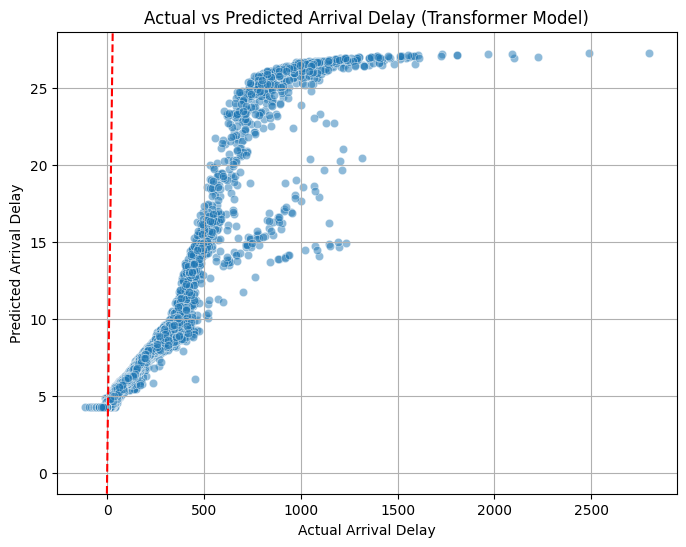

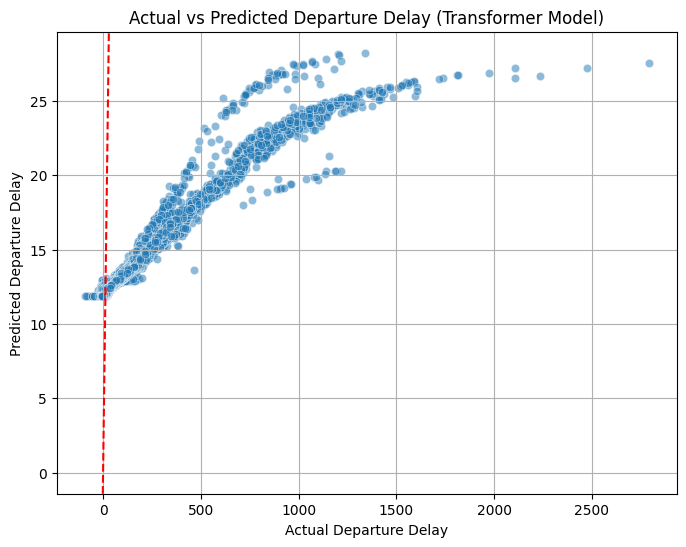

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# 📈 Scatter plot for Arrival Delay
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_arr, y=pred_arr, alpha=0.5)
plt.xlabel("Actual Arrival Delay")
plt.ylabel("Predicted Arrival Delay")
plt.title("Actual vs Predicted Arrival Delay (Transformer Model)")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Line of perfect prediction
plt.grid(True)
plt.show()

# 📈 Scatter plot for Departure Delay
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_dep, y=pred_dep, alpha=0.5)
plt.xlabel("Actual Departure Delay")
plt.ylabel("Predicted Departure Delay")
plt.title("Actual vs Predicted Departure Delay (Transformer Model)")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Line of perfect prediction
plt.grid(True)
plt.show()


In [ ]:
#!pip uninstall -y catboost numpy
#!pip install numpy catboost --no-cache-dir



## CatBoost Regressor

In [29]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Sample 20% of the data for testing
df1_sampled = df1.sample(frac=0.2, random_state=42)

# Select relevant features and target variables
features = ['actual_dep_time', 'actual_arr_time', 'dep_delay', 'arr_delay', 'taxi_out', 'taxi_in',
            'air_time', 'dist', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']

X = df1_sampled[features].values
y_arrival = df1_sampled['arr_delay'].values
y_departure = df1_sampled['dep_delay'].values

# Feature scaling (CatBoost is actually robust without it, but keeping for consistency)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train_arrival, y_test_arrival = train_test_split(X_scaled, y_arrival, test_size=0.2, random_state=42, shuffle=False)
_, _, y_train_departure, y_test_departure = train_test_split(X_scaled, y_departure, test_size=0.2, random_state=42, shuffle=False)

# ---- CatBoost for Arrival Delay ----
cat_arrival = CatBoostRegressor(verbose=0, random_state=42)
cat_arrival.fit(X_train, y_train_arrival)
y_pred_arrival_cb = cat_arrival.predict(X_test)

# ---- CatBoost for Departure Delay ----
cat_departure = CatBoostRegressor(verbose=0, random_state=42)
cat_departure.fit(X_train, y_train_departure)
y_pred_departure_cb = cat_departure.predict(X_test)



## CatBoost Regressor Evaluation

In [30]:
# --- Evaluation ---
rmse_arrival_cb = np.sqrt(mean_squared_error(y_test_arrival, y_pred_arrival_cb))
rmse_departure_cb = np.sqrt(mean_squared_error(y_test_departure, y_pred_departure_cb))

mae_arrival_cb = mean_absolute_error(y_test_arrival, y_pred_arrival_cb)
mse_arrival_cb = mean_squared_error(y_test_arrival, y_pred_arrival_cb)
r2_arrival_cb = r2_score(y_test_arrival, y_pred_arrival_cb)

mae_departure_cb = mean_absolute_error(y_test_departure, y_pred_departure_cb)
mse_departure_cb = mean_squared_error(y_test_departure, y_pred_departure_cb)
r2_departure_cb = r2_score(y_test_departure, y_pred_departure_cb)

# --- Print Metrics ---
print()
print("CatBoost Regressor")
print(f"Metric          | Arrival Delay  | Departure Delay")
print(f"-------------------------------------------------")
print(f"MAE            | {mae_arrival_cb:.4f}       | {mae_departure_cb:.4f}")
print(f"MSE            | {mse_arrival_cb:.4f}       | {mse_departure_cb:.4f}")
print(f"RMSE           | {rmse_arrival_cb:.4f}       | {rmse_departure_cb:.4f}")
print(f"R² Score       | {r2_arrival_cb:.4f}       | {r2_departure_cb:.4f}")


CatBoost Regressor
Metric          | Arrival Delay  | Departure Delay
-------------------------------------------------
MAE            | 0.2587       | 0.2028
MSE            | 15.0366       | 18.1366
RMSE           | 3.8777       | 4.2587
R² Score       | 0.9962       | 0.9950


## CatBoost Regressor Prediction Graph

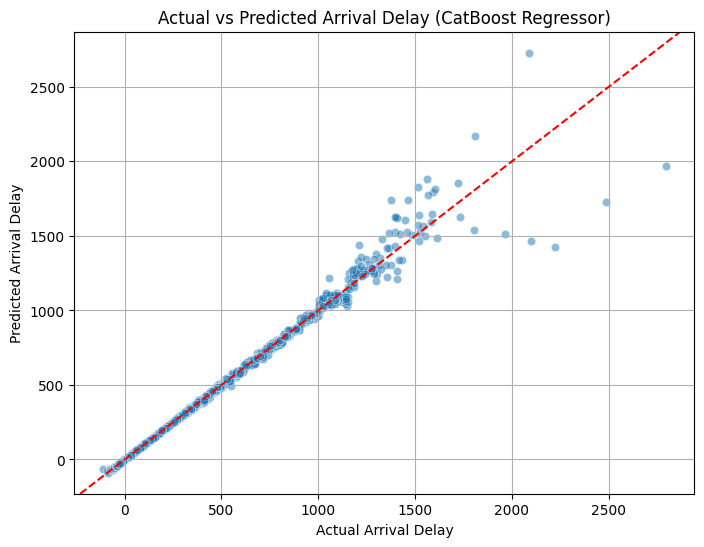

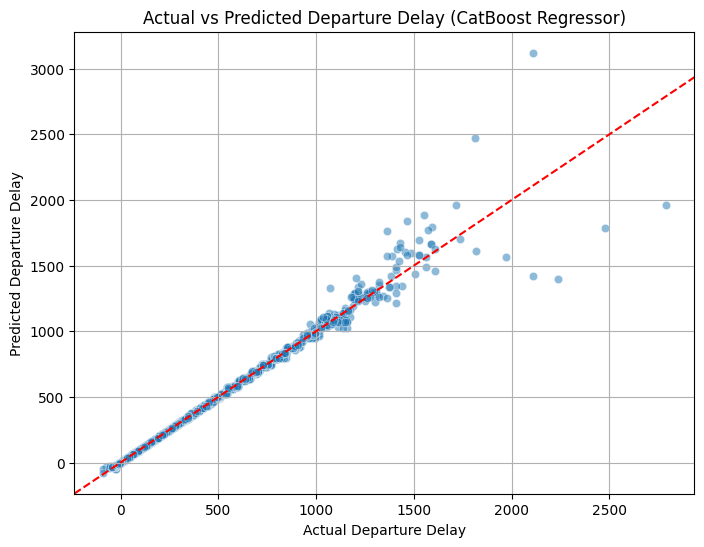

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# 📈 Scatter plot for Arrival Delay (CatBoost)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_arrival, y=y_pred_arrival_cb, alpha=0.5)
plt.xlabel("Actual Arrival Delay")
plt.ylabel("Predicted Arrival Delay")
plt.title("Actual vs Predicted Arrival Delay (CatBoost Regressor)")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Line of perfect prediction
plt.grid(True)
plt.show()

# 📈 Scatter plot for Departure Delay (CatBoost)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_departure, y=y_pred_departure_cb, alpha=0.5)
plt.xlabel("Actual Departure Delay")
plt.ylabel("Predicted Departure Delay")
plt.title("Actual vs Predicted Departure Delay (CatBoost Regressor)")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Line of perfect prediction
plt.grid(True)
plt.show()


## TabNet Regressor

In [32]:
import torch
from pytorch_tabnet.tab_model import TabNetRegressor

# Set a random seed for reproducibility
torch.manual_seed(42)

# --- Train TabNet Regressor for Arrival Delay ---
tabnet_arrival = TabNetRegressor(n_d=8, n_a=8, n_steps=3, gamma=1.5, lambda_sparse=0.001)
tabnet_arrival.fit(X_train, y_train_arrival.reshape(-1, 1), max_epochs=10, batch_size=1024, virtual_batch_size=128)

# Predict using TabNet for Arrival Delay
y_pred_arrival_tabnet = tabnet_arrival.predict(X_test).flatten()

# --- Train TabNet Regressor for Departure Delay ---
tabnet_departure = TabNetRegressor(n_d=8, n_a=8, n_steps=3, gamma=1.5, lambda_sparse=0.001)
tabnet_departure.fit(X_train, y_train_departure.reshape(-1, 1), max_epochs=10, batch_size=1024, virtual_batch_size=128)

# Predict using TabNet for Departure Delay
y_pred_departure_tabnet = tabnet_departure.predict(X_test).flatten()



/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 332.84383|  0:01:06s
epoch 1  | loss: 102.27071|  0:02:11s
epoch 2  | loss: 79.53759|  0:03:16s
epoch 3  | loss: 52.73416|  0:04:23s
epoch 4  | loss: 44.78768|  0:05:27s
epoch 5  | loss: 38.99052|  0:06:32s
epoch 6  | loss: 40.23633|  0:07:38s
epoch 7  | loss: 30.12919|  0:08:44s
epoch 8  | loss: 33.64599|  0:09:50s
epoch 9  | loss: 41.82474|  0:10:55s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 343.13061|  0:01:08s
epoch 1  | loss: 118.49106|  0:02:14s
epoch 2  | loss: 83.42593|  0:03:21s
epoch 3  | loss: 70.47976|  0:04:27s
epoch 4  | loss: 59.69385|  0:05:33s
epoch 5  | loss: 58.81292|  0:06:38s
epoch 6  | loss: 88.05679|  0:07:45s
epoch 7  | loss: 92.43684|  0:08:51s
epoch 8  | loss: 65.0707 |  0:09:57s
epoch 9  | loss: 50.05832|  0:11:03s


## TabNet Regressor Evaluation

In [33]:
# Evaluation
rmse_arrival_tabnet = np.sqrt(mean_squared_error(y_test_arrival, y_pred_arrival_tabnet))
rmse_departure_tabnet = np.sqrt(mean_squared_error(y_test_departure, y_pred_departure_tabnet))

mae_arrival_tabnet = mean_absolute_error(y_test_arrival, y_pred_arrival_tabnet)
mse_arrival_tabnet = mean_squared_error(y_test_arrival, y_pred_arrival_tabnet)
r2_arrival_tabnet = r2_score(y_test_arrival, y_pred_arrival_tabnet)

mae_departure_tabnet = mean_absolute_error(y_test_departure, y_pred_departure_tabnet)
mse_departure_tabnet = mean_squared_error(y_test_departure, y_pred_departure_tabnet)
r2_departure_tabnet = r2_score(y_test_departure, y_pred_departure_tabnet)

# Print performance metrics
print("TabNet Regressor")
print(f"Metric          | Arrival Delay  | Departure Delay")
print(f"-------------------------------------------------")
print(f"MAE            | {mae_arrival_tabnet:.4f}       | {mae_departure_tabnet:.4f}")
print(f"MSE            | {mse_arrival_tabnet:.4f}       | {mse_departure_tabnet:.4f}")
print(f"RMSE           | {rmse_arrival_tabnet:.4f}       | {rmse_departure_tabnet:.4f}")
print(f"R² Score       | {r2_arrival_tabnet:.4f}       | {r2_departure_tabnet:.4f}")


TabNet Regressor
Metric          | Arrival Delay  | Departure Delay
-------------------------------------------------
MAE            | 4.9557       | 5.1336
MSE            | 114.7834       | 201.9971
RMSE           | 10.7137       | 14.2126
R² Score       | 0.9708       | 0.9446


## TabNet Regressor Prediction Graph

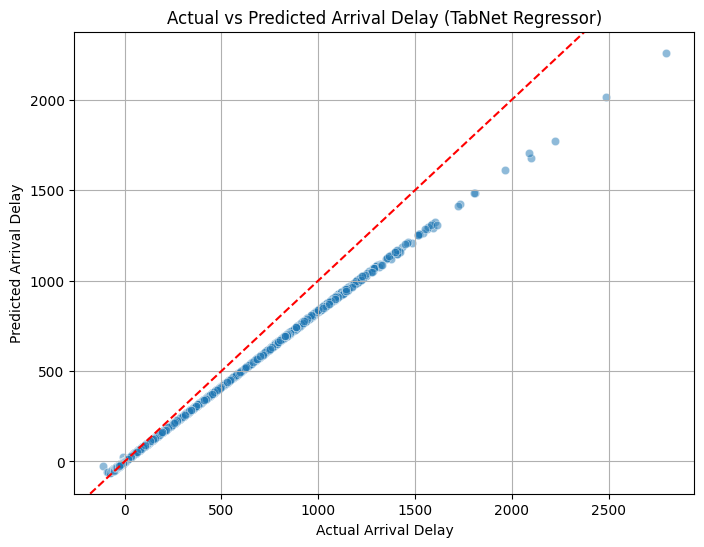

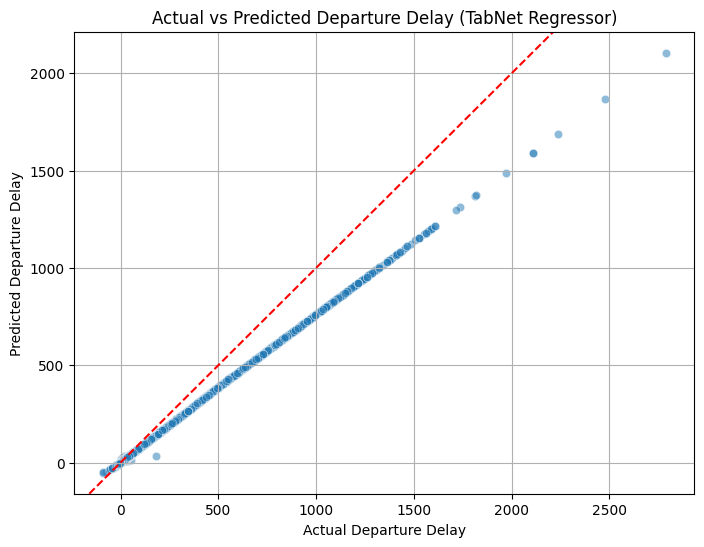

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot for Arrival Delay (TabNet Regressor)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_arrival, y=y_pred_arrival_tabnet, alpha=0.5)
plt.xlabel("Actual Arrival Delay")
plt.ylabel("Predicted Arrival Delay")
plt.title("Actual vs Predicted Arrival Delay (TabNet Regressor)")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Line of perfect prediction
plt.grid(True)
plt.show()

# Scatter plot for Departure Delay (TabNet Regressor)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_departure, y=y_pred_departure_tabnet, alpha=0.5)
plt.xlabel("Actual Departure Delay")
plt.ylabel("Predicted Departure Delay")
plt.title("Actual vs Predicted Departure Delay (TabNet Regressor)")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Line of perfect prediction
plt.grid(True)
plt.show()


## KNN Regressor

In [35]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Sample 20% of the data for testing
df1_sampled = df1.sample(frac=0.2, random_state=42)

# Select relevant features and target variables
features = ['actual_dep_time', 'actual_arr_time', 'dep_delay', 'arr_delay', 'taxi_out', 'taxi_in',
            'air_time', 'dist', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']

X = df1_sampled[features].values
y_arrival = df1_sampled['arr_delay'].values
y_departure = df1_sampled['dep_delay'].values

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.decomposition import PCA

# Apply PCA to reduce dimensions (optional step)
pca = PCA(n_components=5)  # Keep only 5 components
X_scaled_reduced = pca.fit_transform(X_scaled)

# Split data
X_train, X_test, y_train_arrival, y_test_arrival = train_test_split(X_scaled_reduced, y_arrival, test_size=0.2, random_state=42, shuffle=False)
_, _, y_train_departure, y_test_departure = train_test_split(X_scaled_reduced, y_departure, test_size=0.2, random_state=42, shuffle=False)

# ---- KNN for Arrival Delay ----
knn_arrival = KNeighborsRegressor(n_neighbors=5, n_jobs=-1)  # Parallelization
knn_arrival.fit(X_train, y_train_arrival)
y_pred_arrival_knn = knn_arrival.predict(X_test)

# ---- KNN for Departure Delay ----
knn_departure = KNeighborsRegressor(n_neighbors=5, n_jobs=-1)  # Parallelization
knn_departure.fit(X_train, y_train_departure)
y_pred_departure_knn = knn_departure.predict(X_test)



## KNN Regressor valuation

In [36]:
# --- Evaluation ---
rmse_arrival_knn = np.sqrt(mean_squared_error(y_test_arrival, y_pred_arrival_knn))
rmse_departure_knn = np.sqrt(mean_squared_error(y_test_departure, y_pred_departure_knn))

mae_arrival_knn = mean_absolute_error(y_test_arrival, y_pred_arrival_knn)
mse_arrival_knn = mean_squared_error(y_test_arrival, y_pred_arrival_knn)
r2_arrival_knn = r2_score(y_test_arrival, y_pred_arrival_knn)

mae_departure_knn = mean_absolute_error(y_test_departure, y_pred_departure_knn)
mse_departure_knn = mean_squared_error(y_test_departure, y_pred_departure_knn)
r2_departure_knn = r2_score(y_test_departure, y_pred_departure_knn)

# --- Print Metrics ---
print()
print("KNN Regressor")
print(f"Metric          | Arrival Delay  | Departure Delay")
print(f"-------------------------------------------------")
print(f"MAE            | {mae_arrival_knn:.4f}       | {mae_departure_knn:.4f}")
print(f"MSE            | {mse_arrival_knn:.4f}       | {mse_departure_knn:.4f}")
print(f"RMSE           | {rmse_arrival_knn:.4f}       | {rmse_departure_knn:.4f}")
print(f"R² Score       | {r2_arrival_knn:.4f}       | {r2_departure_knn:.4f}")



KNN Regressor
Metric          | Arrival Delay  | Departure Delay
-------------------------------------------------
MAE            | 3.4715       | 3.4323
MSE            | 22.3810       | 26.3975
RMSE           | 4.7309       | 5.1378
R² Score       | 0.9943       | 0.9928


## KNN Regressor Prediction Graph

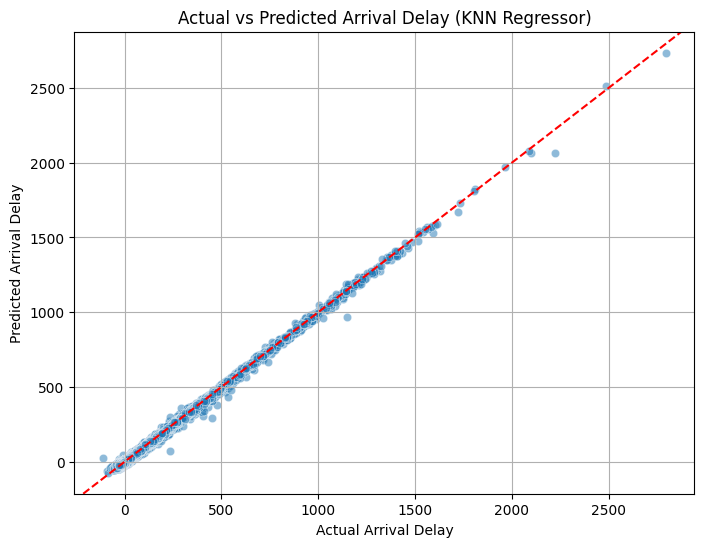

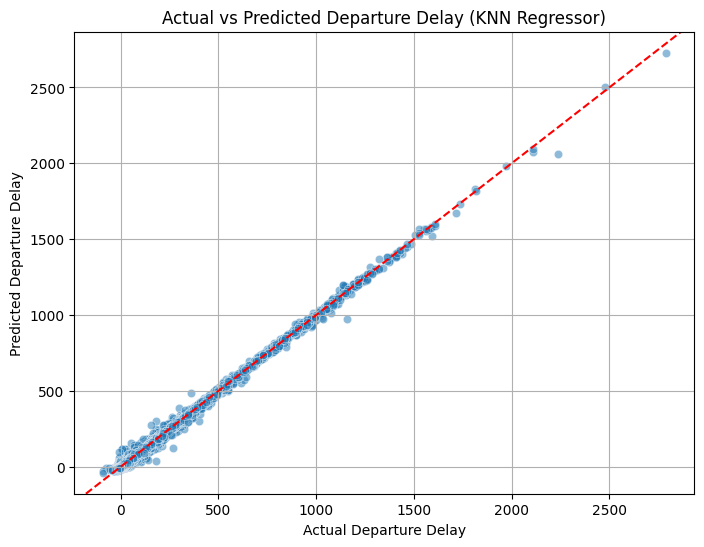

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# 📈 Scatter plot for Arrival Delay (KNN)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_arrival, y=y_pred_arrival_knn, alpha=0.5)
plt.xlabel("Actual Arrival Delay")
plt.ylabel("Predicted Arrival Delay")
plt.title("Actual vs Predicted Arrival Delay (KNN Regressor)")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Line of perfect prediction
plt.grid(True)
plt.show()

# 📈 Scatter plot for Departure Delay (KNN)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_departure, y=y_pred_departure_knn, alpha=0.5)
plt.xlabel("Actual Departure Delay")
plt.ylabel("Predicted Departure Delay")
plt.title("Actual vs Predicted Departure Delay (KNN Regressor)")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Line of perfect prediction
plt.grid(True)
plt.show()


# AdaBoost Regressor

In [38]:
import numpy as np
import pandas as pd
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Sample 20% of the data for testing
df1_sampled = df1.sample(frac=0.2, random_state=42)

# Select relevant features and target variables
features = ['actual_dep_time', 'actual_arr_time', 'dep_delay', 'arr_delay', 'taxi_out', 'taxi_in',
            'air_time', 'dist', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']

X = df1_sampled[features].values
y_arrival = df1_sampled['arr_delay'].values
y_departure = df1_sampled['dep_delay'].values

# Feature scaling (AdaBoost is sensitive to feature scaling)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train_arrival, y_test_arrival = train_test_split(X_scaled, y_arrival, test_size=0.2, random_state=42, shuffle=False)
_, _, y_train_departure, y_test_departure = train_test_split(X_scaled, y_departure, test_size=0.2, random_state=42, shuffle=False)

# ---- AdaBoost for Arrival Delay ----
ada_arrival = AdaBoostRegressor(n_estimators=50, random_state=42)
ada_arrival.fit(X_train, y_train_arrival)
y_pred_arrival_ada = ada_arrival.predict(X_test)

# ---- AdaBoost for Departure Delay ----
ada_departure = AdaBoostRegressor(n_estimators=50, random_state=42)
ada_departure.fit(X_train, y_train_departure)
y_pred_departure_ada = ada_departure.predict(X_test)


# AdaBoost Regressor Evaluation

In [39]:
# --- Evaluation ---
rmse_arrival_ada = np.sqrt(mean_squared_error(y_test_arrival, y_pred_arrival_ada))
rmse_departure_ada = np.sqrt(mean_squared_error(y_test_departure, y_pred_departure_ada))

mae_arrival_ada = mean_absolute_error(y_test_arrival, y_pred_arrival_ada)
mse_arrival_ada = mean_squared_error(y_test_arrival, y_pred_arrival_ada)
r2_arrival_ada = r2_score(y_test_arrival, y_pred_arrival_ada)

mae_departure_ada = mean_absolute_error(y_test_departure, y_pred_departure_ada)
mse_departure_ada = mean_squared_error(y_test_departure, y_pred_departure_ada)
r2_departure_ada = r2_score(y_test_departure, y_pred_departure_ada)

# --- Print Metrics ---
print()
print("AdaBoost Regressor")
print(f"Metric          | Arrival Delay  | Departure Delay")
print(f"-------------------------------------------------")
print(f"MAE            | {mae_arrival_ada:.4f}       | {mae_departure_ada:.4f}")
print(f"MSE            | {mse_arrival_ada:.4f}       | {mse_departure_ada:.4f}")
print(f"RMSE           | {rmse_arrival_ada:.4f}       | {rmse_departure_ada:.4f}")
print(f"R² Score       | {r2_arrival_ada:.4f}       | {r2_departure_ada:.4f}")



AdaBoost Regressor
Metric          | Arrival Delay  | Departure Delay
-------------------------------------------------
MAE            | 15.4947       | 18.0458
MSE            | 358.2151       | 379.4576
RMSE           | 18.9266       | 19.4797
R² Score       | 0.9090       | 0.8958


# AdaBoost Regressor Prediction Grapph

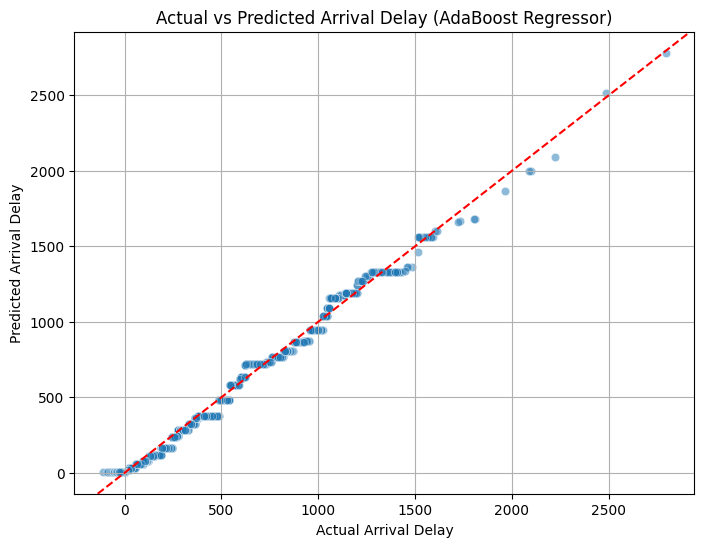

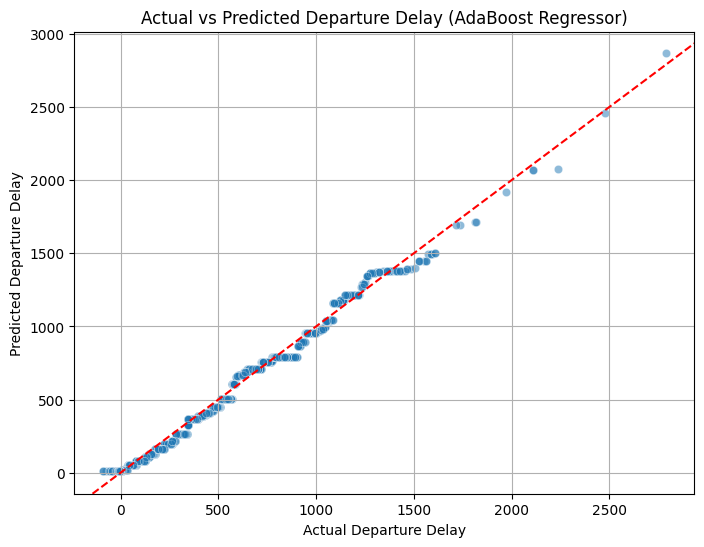

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# 📈 Scatter plot for Arrival Delay (AdaBoost)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_arrival, y=y_pred_arrival_ada, alpha=0.5)
plt.xlabel("Actual Arrival Delay")
plt.ylabel("Predicted Arrival Delay")
plt.title("Actual vs Predicted Arrival Delay (AdaBoost Regressor)")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Line of perfect prediction
plt.grid(True)
plt.show()

# 📈 Scatter plot for Departure Delay (AdaBoost)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_departure, y=y_pred_departure_ada, alpha=0.5)
plt.xlabel("Actual Departure Delay")
plt.ylabel("Predicted Departure Delay")
plt.title("Actual vs Predicted Departure Delay (AdaBoost Regressor)")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Line of perfect prediction
plt.grid(True)
plt.show()


## Evaluation of All Models (Arrival Delays)

In [43]:
# --- Storing results in a DataFrame ---
models = ["CNN-LSTM", "ATT-BI-LSTM", "Random Forest", "Gradient Boosting", "XGBoost", "LLM-Transformer", "CatBoost", "TabNet", "KNN","AdaBoost"]

arrival_metrics = {
    "Model": models,
    "MAE": [mae_arrival0, mae_arrival1, mae_arrival2, mae_arrival_2, mae_arrival_3, mae_arrival_4, mae_arrival_cb, mae_arrival_tabnet, mae_arrival_knn, mae_arrival_ada],
    "MSE": [mse_arrival0, mse_arrival1, mse_arrival2, mse_arrival_2, mse_arrival_3, mse_arrival_4, mse_arrival_cb, mse_arrival_tabnet, mse_arrival_knn, mse_arrival_ada],
    "RMSE": [rmse_arrival0, rmse_arrival1, rmse_arrival_1, rmse_arrival1, rmse_arrival2, rmse_arrival_4, rmse_arrival_cb, rmse_arrival_tabnet, rmse_arrival_knn, rmse_arrival_ada],
    "R² Score": [r2_arrival0, r2_arrival1, r2_arrival2, r2_arrival_2, r2_arrival_3, r2_arrival_4, r2_arrival_cb, r2_arrival_tabnet, r2_arrival_knn,r2_arrival_ada]
}

df_arrival = pd.DataFrame(arrival_metrics)

departure_metrics = {
    "Model": models,
    "MAE": [mae_departure0, mae_departure1, mae_departure2, mae_departure_2, mae_departure_3, mae_departure_4, mae_departure_cb, mae_departure_tabnet, mae_departure_knn, mae_departure_ada],
    "MSE": [mse_departure0, mse_departure1, mse_departure2, mse_departure_2, mse_departure_3, mse_departure_4, mse_departure_cb, mse_departure_tabnet, mse_departure_knn, mse_departure_ada],
    "RMSE": [rmse_departure0, rmse_departure1, rmse_departure_1, rmse_departure1, rmse_departure2, rmse_departure_4, rmse_departure_cb, rmse_departure_tabnet, rmse_departure_knn, rmse_departure_ada],
    "R² Score": [r2_departure0, r2_departure1, r2_departure2, r2_departure_2, r2_departure_3, r2_departure_4, r2_departure_cb, r2_departure_tabnet, r2_departure_knn, r2_departure_ada]
}

df_departure = pd.DataFrame(departure_metrics)

print(df_arrival)


               Model        MAE          MSE       RMSE  R² Score
0           CNN-LSTM   0.281473    32.685391   5.717114  0.991696
1        ATT-BI-LSTM   0.411706    13.783606   0.316668  0.996498
2      Random Forest   0.001503     0.042051   0.205063  0.999989
3  Gradient Boosting   0.024563     0.100279   0.316668  0.999975
4            XGBoost   0.576873    77.682346   8.813759  0.980265
5    LLM-Transformer  29.236998  3802.476861   8.813759  0.033969
6           CatBoost   0.258697    15.036566   3.877701  0.996180
7             TabNet   4.955707   114.783408  10.713702  0.970839
8                KNN   3.471534    22.380977   4.730854  0.994314
9           AdaBoost  15.494673   358.215074  18.926571  0.908994


## Evaluation of All Models (Departure Delays)

In [44]:
print("\nDeparture Delay Performance Metrics:\n")
print(df_departure)


Departure Delay Performance Metrics:

               Model        MAE          MSE       RMSE  R² Score
0           CNN-LSTM   0.517473    49.537073   7.038258  0.986403
1        ATT-BI-LSTM   0.379680    15.416427   0.257410  0.995769
2      Random Forest   0.001512     0.043469   0.208491  0.999988
3  Gradient Boosting   0.020361     0.066260   0.257410  0.999982
4            XGBoost   0.589395    78.693266   8.870923  0.978401
5    LLM-Transformer  26.086486  3555.116429   8.870923  0.024206
6           CatBoost   0.202835    18.136649   4.258714  0.995022
7             TabNet   5.133558   201.997061  14.212567  0.944557
8                KNN   3.432261    26.397493   5.137849  0.992755
9           AdaBoost  18.045803   379.457624  19.479672  0.895848
